In [1]:
from sys import thread_info

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [2]:
X=mnist.data
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [3]:
y = mnist.target
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [5]:
def plot_digit(image_data):
    sns.set_style('white')
    plt.figure(figsize=(6,6))
    image = image_data.reshape(28,28)
    sns.heatmap(
        image,
        cmap='binary',
        cbar=False,
        xticklabels=False,
        yticklabels=False,
    )

    plt.axis('off')


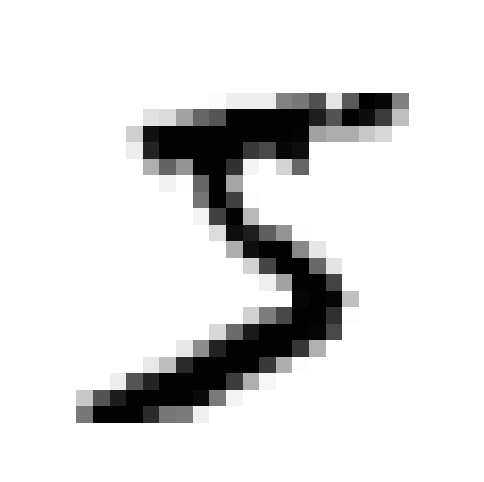

In [6]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

# train test split

In [7]:
X_train, X_test, y_train, y_test = X[0:60000], X[60000:], y[0:60000], y[60000:]


# Training a Binary Classifier

In [8]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [9]:
y_test_5

array([False, False, False, ..., False,  True, False], shape=(10000,))

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [12]:
y_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
skf= StratifiedKFold(n_splits=3)
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=skf, scoring='accuracy')
# Print results
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Cross-validation scores: [0.95035 0.96035 0.9604 ]
Mean accuracy: 0.957 (+/- 0.009)


In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=skf)

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  xticklabels = ["NO 5", "YES 5"] , yticklabels = ["NO 5", "YES 5"], cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    plt.close()

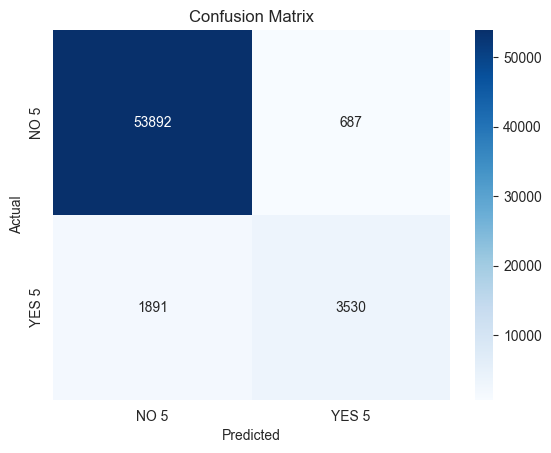

In [17]:
plot_confusion_matrix(y_train_5, y_train_pred)

- True Negatives (TN): Correctly predicted "not 5"
- False Positives (FP): Incorrectly predicted "5" when it was actually "not 5"
- False Negatives (FN): Incorrectly predicted "not 5" when it was actually "5"
- True Positives (TP): Correctly predicted "5"


- 53,892 digits were correctly identified as "not 5" (TN)
- 687 digits were wrongly identified as "5" (FP)
- 1,891 digits that were "5" were missed (FN)
- 3,530 digits were correctly identified as "5" (TP)

In [18]:
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.837
Recall: 0.651
F1 Score: 0.733


In [19]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=skf, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

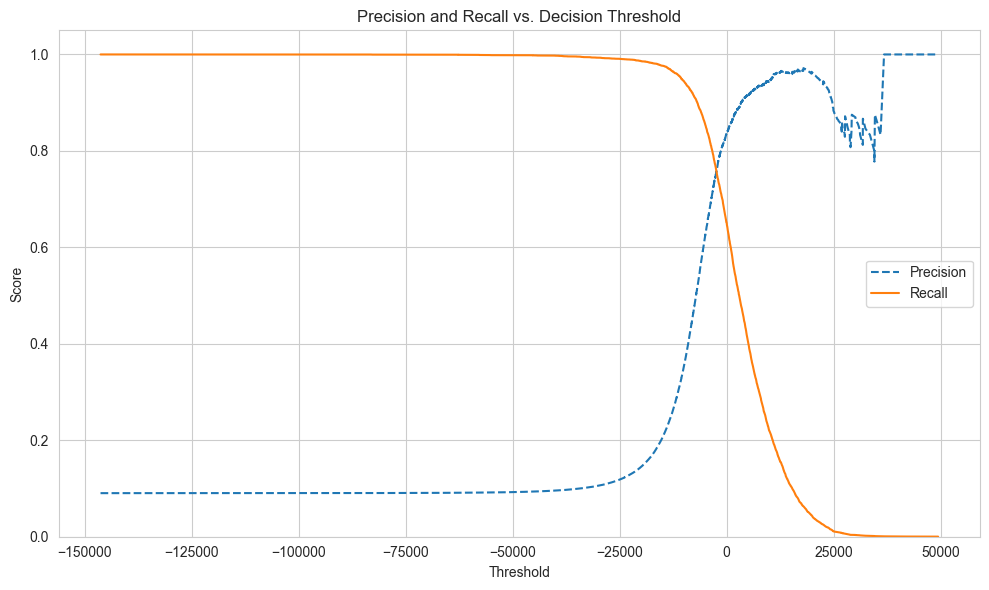

In [21]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Create figure and axes
    plt.figure(figsize=(10, 6))

    # Set style
    sns.set_style("whitegrid")

    # Create the plot
    sns.lineplot(x=thresholds, y=precisions[:-1], label="Precision", linestyle="--")
    sns.lineplot(x=thresholds, y=recalls[:-1], label="Recall")

    # Add vertical line at threshold
    threshold = thresholds[np.argmin(np.abs(precisions[:-1] - recalls[:-1]))]  # Find threshold where precision=recall

    # plt.axvline(x=3370, color='k', linestyle=':', label='threshold')

    # Customize the plot
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs. Decision Threshold")

    # Set axis limits
    plt.ylim(0, 1.05)

    # Add legend
    plt.legend(loc="center right")

    plt.tight_layout()
    plt.show()

# Call the function
plot_precision_recall_vs_threshold(precision, recall, thresholds)

In [22]:
idx_for_90_precision = (precision>=0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
roc_auc = roc_auc_score(y_train_5, y_scores)

print(f"False Positive Rate shape: {fpr.shape}")
print(f"True Positive Rate shape: {tpr.shape}")
print(f"Thresholds shape: {thresholds.shape}")
print(f"ROC AUC Score: {roc_auc:.3f}")


False Positive Rate shape: (3908,)
True Positive Rate shape: (3908,)
Thresholds shape: (3908,)
ROC AUC Score: 0.960


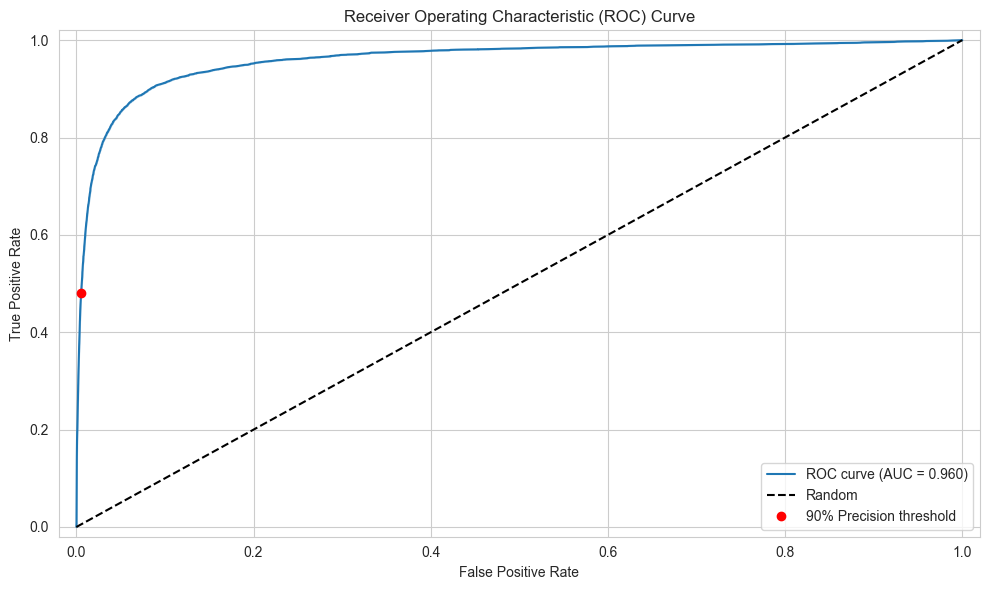

In [24]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Find the point on ROC curve corresponding to 90% precision threshold
    idx = np.argmin(np.abs(thresholds - threshold_for_90_precision))
    plt.plot(fpr[idx], tpr[idx], 'ro', label='90% Precision threshold')

    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])

    plt.tight_layout()
    plt.show()

# Call the function
plot_roc_curve(fpr, tpr, roc_auc)

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=skf, method='predict_proba')

In [26]:
y_prob_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]], shape=(60000, 2))

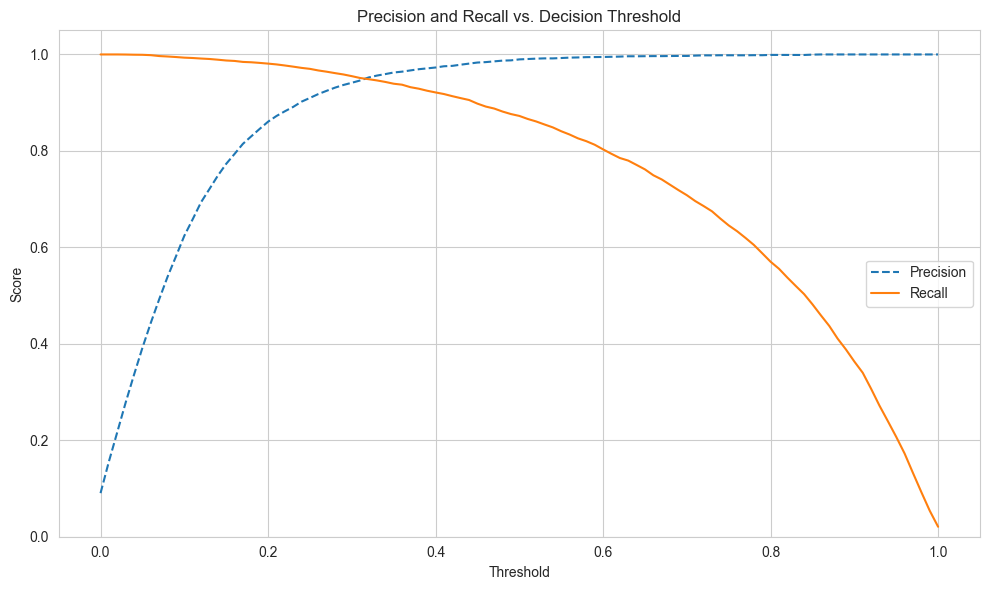

False Positive Rate shape: (101,)
True Positive Rate shape: (101,)
Thresholds shape: (101,)
ROC AUC Score: 0.960


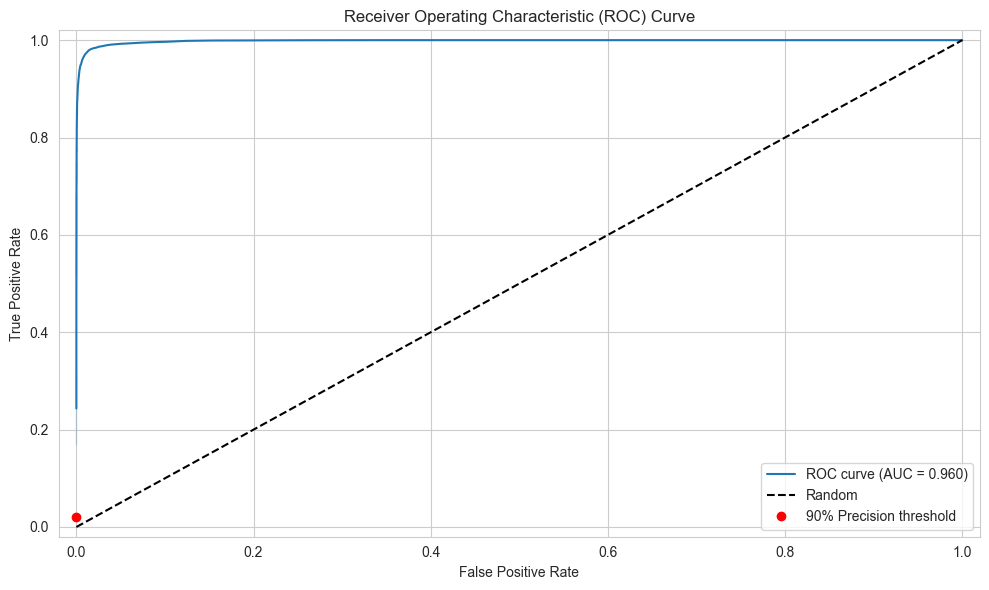

In [27]:
y_scores_forest = y_prob_forest[:, 1]  # Probability of positive class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores_forest)

roc_auc = roc_auc_score(y_train_5, y_scores)

print(f"False Positive Rate shape: {fpr.shape}")
print(f"True Positive Rate shape: {tpr.shape}")
print(f"Thresholds shape: {thresholds.shape}")
print(f"ROC AUC Score: {roc_auc:.3f}")

plot_roc_curve(fpr, tpr, roc_auc)